# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

PCMCI is described here:
J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, 
Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) 
https://advances.sciencemag.org/content/5/11/eaau4996

For further versions of PCMCI (e.g., PCMCI+, LPCMCI, etc.), see the corresponding tutorials.

This tutorial explains the causal assumptions and gives walk-through examples. See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

from tigramite.models import LinearMediation, Prediction

## Causal assumptions

Having introduced the basic functionality, we now turn to a discussion of the assumptions underlying a causal interpretation:

  - **Faithfulness / Stableness:** *Independencies in data arise not from coincidence, but rather from causal structure* or, expressed differently, *If two variables are independent given some other subset of variables, then they are not connected by a causal link in the graph*.
  
  - **Causal Sufficiency:** *Measured variables include all of the common causes.*
  
  - **Causal Markov Condition:** *All the relevant probabilistic information that can be obtained from the system is contained in its direct causes* or, expressed differently, *If two variables are not connected in the causal graph given some set of conditions (see Runge Chaos 2018 for further definitions), then they are conditionally independent*.
  
  - **No contemporaneous effects:** *There are no causal effects at lag zero.*
  
  - **Stationarity**
  
  - **Parametric assumptions of independence tests** (these were already discussed in basic tutorial)

### Faithfulness

Faithfulness, as stated above, is an expression of the assumption that the independencies we measure come from the causal structure, i.e., the time series graph, and cannot occur due to some fine tuning of the parameters. Another unfaithful case are processes containing *purely* deterministic dependencies, i.e., $Y=f(X)$, without any noise. We illustrate these cases in the following.

#### Fine tuning

Suppose in our model we have two ways in which $X^0$ causes $X^2$, a direct one, and an indirect effect $X^0\to X^1 \to X^2$ as realized in the following model:

\begin{align*}
    X^0_t &= \eta^0_t\\
    X^1_t &= 0.6 X^0_{t-1} + \eta^1_t\\
    X^2_t &= 0.6 X^1_{t-1} - 0.36 X^0_{t-2} + \eta^2_t\\
\end{align*}

In [2]:
seed=1
random_state = np.random.default_rng(seed=seed)
data = random_state.standard_normal((500, 3))
for t in range(1, 500):
#     data[t, 0] += 0.6*data[t-1, 1]
    data[t, 1] += 0.6*data[t-1, 0]
    data[t, 2] += 0.6*data[t-1, 1] - 0.36*data[t-2, 0]
    
var_names = [r'$X^0$', r'$X^1$', r'$X^2$']
dataframe = pp.DataFrame(data, var_names=var_names)
# tp.plot_timeseries(dataframe)

Since here $X^2_t = 0.6 X^1_{t-1} - 0.36 X^0_{t-2} + \eta^2_t = 0.6 (0.6 X^0_{t-2} + \eta^1_{t-1}) - 0.36 X^0_{t-2} + \eta^2_t = 0.36 X^0_{t-2} - 0.36 X^0_{t-2} + ...$, there is no unconditional dependency $X^0_{t-2} \to X^2_t$ and the link is not detected in the condition-selection step: 

In [3]:
parcorr = ParCorr()
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
all_parents = pcmci_parcorr.run_pc_stable(tau_max=2, pc_alpha=0.2)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 1 link(s):
        ($X^0$ -1): max_pval = 0.09500, min_val = -0.075

    Variable $X^1$ has 1 link(s):
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.527

    Variable $X^2$ has 2 link(s):
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.394
        ($X^0$ -1): max_pval = 0.15990, min_val = -0.063


However, since the other parent of $X^2$, namely $X^1_{t-1}$ *is* detected, the MCI step conditions on $X^1_{t-1}$ and can reveal the true underlying graph (in this particular case):

In [4]:
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2, alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 1 link(s):
        ($X^0$ -1): max_pval = 0.09500, min_val = -0.075

    Variable $X^1$ has 1 link(s):
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.527

    Variable $X^2$ has 2 link(s):
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.394
        ($X^0$ -1): max_pval = 0.15990, min_val = -0.063

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 2
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.01:

    Variable $X^0$ has 0 link(s):

    Variable $X^1$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | val =  0.530

    Variable $X^2$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | val =  0.479
        ($X^0$ -2): pval = 0.00000 | val = -0.294


Note, however, that this is not always the case and such cancellation, even though a pathological case, can present a problem especially for smaller sample sizes.

#### Deterministic dependencies

Another violation of faithfulness can happen due to *purely* deterministic dependencies as shown here:

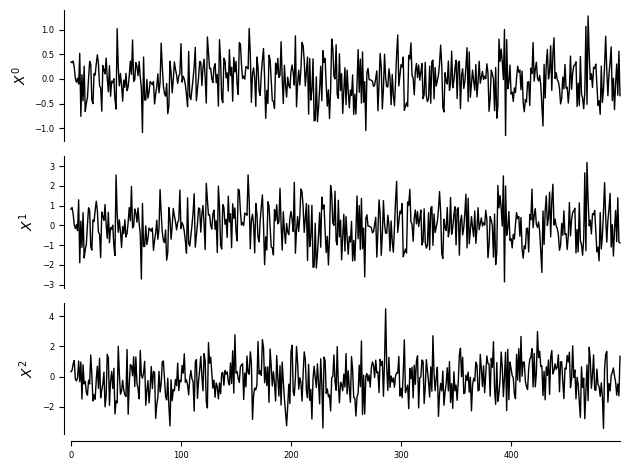

In [5]:
seed=1
random_state = np.random.default_rng(seed=seed)
data = random_state.standard_normal((500, 3))
for t in range(1, 500):
    data[t, 0] = 0.4*data[t-1, 1]
    data[t, 2] += 0.3*data[t-2, 1] + 0.7*data[t-1, 0]
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Variable $X^0$

Iterating through pc_alpha = [0.2]:

# pc_alpha = 0.2 (1/1):

Testing condition sets of dimension 0:

    Link ($X^0$ -1) -?> $X^0$ (1/6):
    Subset 0: () gives pval = 0.51104 / val =  0.030
    Non-significance detected.

    Link ($X^0$ -2) -?> $X^0$ (2/6):
    Subset 0: () gives pval = 0.77977 / val =  0.013
    Non-significance detected.

    Link ($X^1$ -1) -?> $X^0$ (3/6):
    Subset 0: () gives pval = 0.00000 / val =  1.000
    No conditions of dimension 0 left.

    Link ($X^1$ -2) -?> $X^0$ (4/6):
    Subset 0: () gives pval = 0.51104 / val =  0.030
    Non-significance detected.

    Link ($X^2$ -1) -?> $X^0$ (5/6):
    Subset 0: () gives pval = 0.20746 / val = -0.057
    Non-significance detected.

    Link ($X^2$ -2) -?> $X^0$ (6/6):
    Subset 0: () gives pval = 0.19827 / v

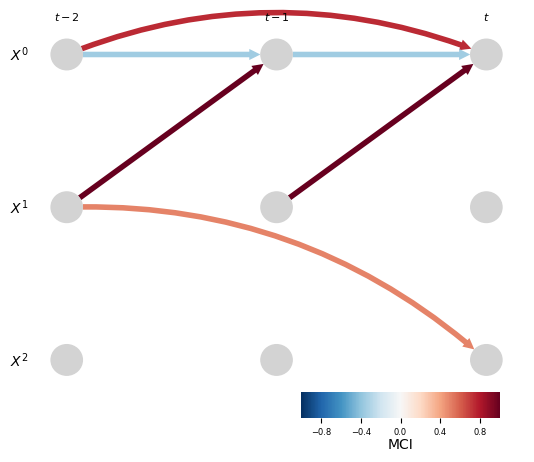

In [6]:
parcorr = ParCorr()
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=2)
results = pcmci_parcorr.run_pcmci(tau_max=2, pc_alpha=0.2, alpha_level = 0.01)

# Plot time series graph
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

Here the partial correlation $X^1_{t-1} \to X^0_t$ is exactly 1. Since these now represent the same variable, the true link $X^0_{t-1} \to X^2_t$ cannot be detected anymore since we condition on $X^1_{t-2}$. Deterministic copies of other variables should be excluded from the analysis.

### Causal sufficiency

Causal sufficiency demands that the set of variables contains all common causes of any two variables. This assumption is mostly violated when analyzing open complex systems outside a confined experimental setting. Any link estimated from a causal discovery algorithm could become non-significant if more variables are included in the analysis. 
Observational causal inference assuming causal sufficiency should generally be seen more as one step towards a physical process understanding. There exist, however, algorithms that take into account and can expclicitely represent confounded links (e.g., the FCI algorithm and LPCMCI). Causal discovery can greatly help in an explorative model building analysis to get an idea of potential drivers. In particular, the absence of a link allows for a more robust conclusion: If there is no evidence for a statistical dependency, then a physical mechanism is less likely (assuming that the other assumptions hold). 

See Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.
for alternative approaches that do not necessitate Causal Sufficiency.


#### Unobserved driver / latent variable

For the common driver process, consider that the common driver was not measured:

In [7]:
seed=1
random_state = np.random.default_rng(seed=seed)
data = random_state.standard_normal((10000, 5))
a = 0.8
for t in range(5, 10000):
    data[t, 0] += a*data[t-1, 0]
    data[t, 1] += a*data[t-1, 1] + 0.5*data[t-1, 0]
    data[t, 2] += a*data[t-1, 2] + 0.5*data[t-1, 1] + 0.5*data[t-1, 4]
    data[t, 3] += a*data[t-1, 3] + 0.5*data[t-2, 4]
    data[t, 4] += a*data[t-1, 4]

# tp.plot_timeseries(dataframe)
obsdata = data[:,[0, 1, 2, 3]]
var_names_lat = ['W', 'Y', 'X', 'Z', 'U']


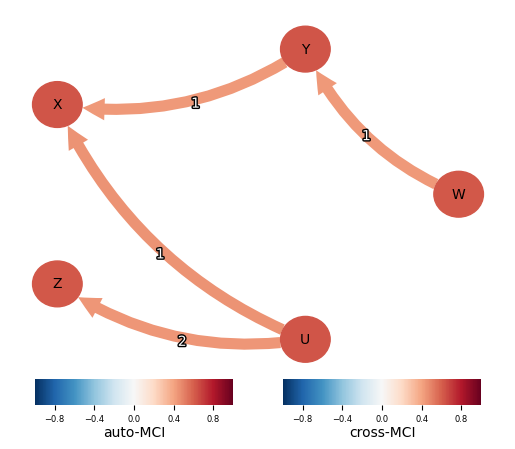

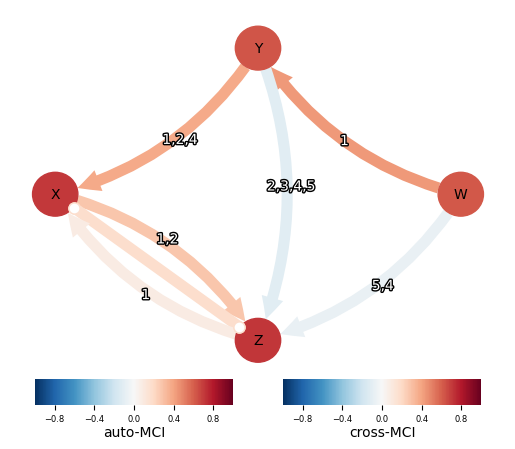

In [8]:
for data_here in [data, obsdata]:
    dataframe = pp.DataFrame(data_here)
    parcorr = ParCorr()
    pcmci_parcorr = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=parcorr,
        verbosity=0)
    results = pcmci_parcorr.run_pcmci(tau_max=5, pc_alpha=0.1, alpha_level = 0.001)

    tp.plot_graph(
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names_lat,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        ); plt.show()

The upper plot shows the true causal graph if all variables are observed. The lower graph shows the case where variable $U$ is hidden. Then several spurious links appear: (1) $X\to Z$ and (2) links from $Y$ and $W$ to $Z$, which is counterintuitive because there is no possible indirect pathway (see upper graph). What's the reason? The culprit is the *collider* $X$: MCI (or FullCI and any other causal measure conditioning on the entire past) between $Y$ and $Z$ is conditioned on the parents of $Z$, which includes $X$ here in the lower latent graph. But then conditioning on a collider opens up the paths from $Y$ and $W$ to $Z$ and makes them dependent.

#### Solar forcing

In a geoscientific context, the solar forcing typically is a strong common driver of many processes. To remove this trivial effect, time series are typically anomalized, that is, the average seasonal cycle is subtracted. But one could also include the solar forcing explicitely as shown here via a sine wave for an artificial example. We've also made the time series more realistic by adding an auto-dependency on their past values.

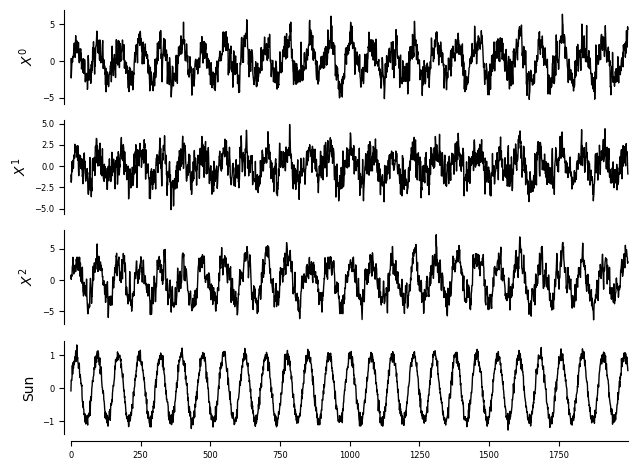

In [9]:
T = 2000
seed=42
random_state = np.random.default_rng(seed=seed)
data = random_state.standard_normal((T, 4))

# Simple sun
data[:,3] = np.sin(np.arange(T)*20/np.pi) + 0.1*np.random.randn(T)
c = 0.8
for t in range(1, T):
    data[t, 0] += 0.4*data[t-1, 0] + 0.4*data[t-1, 1] + c*data[t-1,3]
    data[t, 1] += 0.5*data[t-1, 1] + c*data[t-1,3]
    data[t, 2] += 0.6*data[t-1, 2] + 0.3*data[t-2, 1] + c*data[t-1,3]
dataframe = pp.DataFrame(data, var_names=[r'$X^0$', r'$X^1$', r'$X^2$', 'Sun'])
tp.plot_timeseries(dataframe); plt.show()

If we do not account for the common solar forcing, there will be many spurious links:

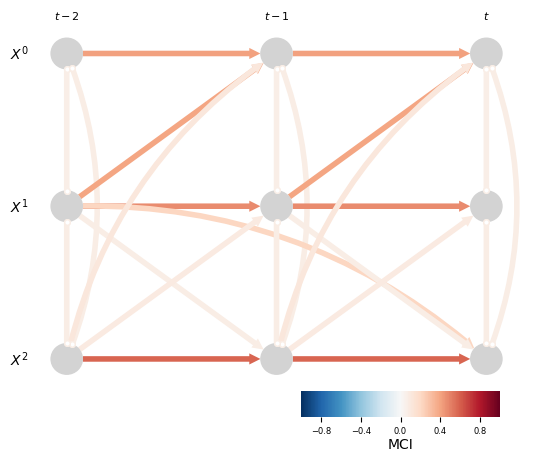

In [10]:
parcorr = ParCorr()
dataframe_nosun = pp.DataFrame(data[:,[0,1,2]], var_names=[r'$X^0$', r'$X^1$', r'$X^2$'])
pcmci_parcorr = PCMCI(
    dataframe=dataframe_nosun, 
    cond_ind_test=parcorr,
    verbosity=0)
tau_max = 2
results = pcmci_parcorr.run_pcmci(tau_max=tau_max, pc_alpha=0.2, alpha_level = 0.01)

# Plot time series graph
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

However, if we explicitely include the solar forcing variable (which we assume is known in this case), we can identify the correct causal graph. Since we are not interested in the drivers of the solar forcing variable, we don't attempt to reconstruct its parents. This can be achieved by restricting ``link_assumptions`` (``selected_links`` is now deprecated).

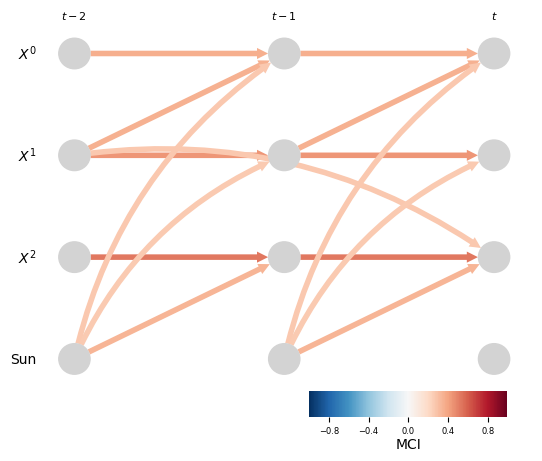

In [11]:
parcorr = ParCorr()
# Only estimate parents of variables 0, 1, 2
link_assumptions = {}
for j in range(4):
    if j in [0, 1, 2]:
        # Directed lagged links
        link_assumptions[j] = {(var, -lag): '-?>' for var in [0, 1, 2]
                         for lag in range(1, tau_max + 1)}
        # Unoriented contemporaneous links
        link_assumptions[j].update({(var, 0): 'o?o' for var in [0, 1, 2] if var != j})
        # Directed lagged and contemporaneous links from the sun (3)
        link_assumptions[j].update({(var, -lag): '-?>' for var in [3]
                         for lag in range(0, tau_max + 1)})
    else:
        link_assumptions[j] = {}
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_max=tau_max, pc_alpha=0.2, 
                                  link_assumptions=link_assumptions, alpha_level = 0.01)

# Plot time series graph
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=[r'$X^0$', r'$X^1$', r'$X^2$', 'Sun'],
    link_colorbar_label='MCI',
    ); plt.show()

#### Time sub-sampling

Sometimes a time series might be sub-sampled, that is the measurements are less frequent than the true underlying time-dependency. Consider the following process:

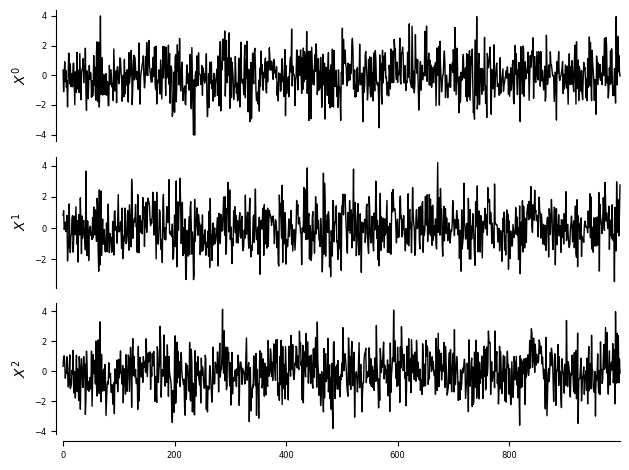

In [12]:
seed=1
random_state = np.random.default_rng(seed=seed)
data = random_state.standard_normal((1000, 3))

for t in range(1, 1000):
    data[t, 0] += 0.*data[t-1, 0] + 0.6*data[t-1,2]
    data[t, 1] += 0.*data[t-1, 1] + 0.6*data[t-1,0]
    data[t, 2] += 0.*data[t-1, 2] + 0.6*data[t-1,1]
dataframe = pp.DataFrame(data, var_names=[r'$X^0$', r'$X^1$', r'$X^2$'])
tp.plot_timeseries(dataframe); plt.show()

With the original time sampling we obtain the correct causal graph:

In [13]:
pcmci_parcorr = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr())
results = pcmci_parcorr.run_pcmci(tau_min=0,tau_max=2, pc_alpha=0.2, alpha_level = 0.01)

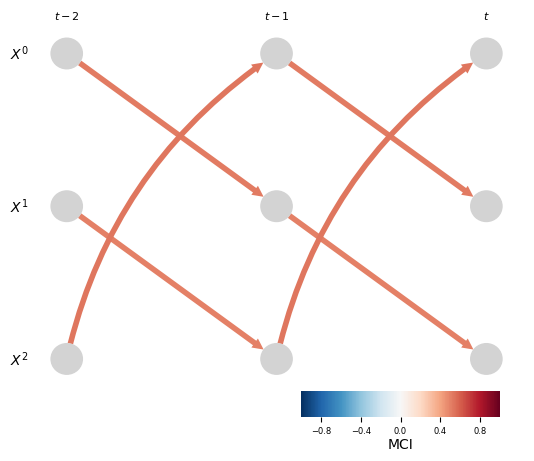

In [14]:
# Plot time series graph
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

If we sub-sample the data, very counter-intuitive links can appear. The true causal loop gets detected in the wrong direction:

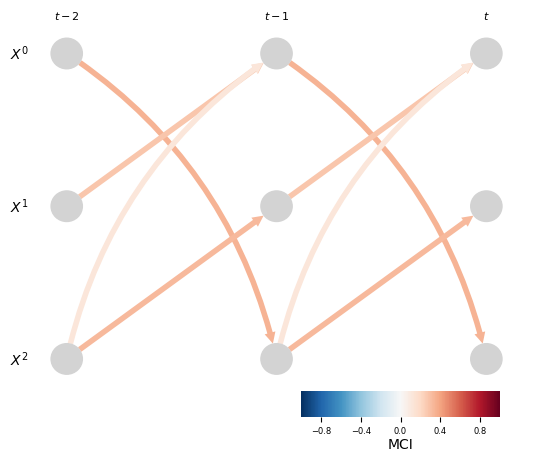

In [15]:
sampled_data = data[::2]
pcmci_parcorr = PCMCI(dataframe=pp.DataFrame(sampled_data, var_names=var_names), 
                      cond_ind_test=ParCorr(), verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_min=0, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
# Plot time series graph
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

If causal lags are smaller than the time sampling, such problems may occur. Causal inference for sub-sampled data is still an active area of research.

### Causal Markov condition

The Markov condition can be rephrased as assuming that the noises driving each variable are independent of each other *and* independent in time (*iid*). This is violated in the following example where each variable is driven by *1/f* noise which refers to the scaling of the power spectrum. *1/f* noise can be generated by averaging AR(1) processes (http://www.scholarpedia.org/article/1/f_noise) which means that the noise is not independent in time anymore (even though the noise terms of each individual variable are still independent). Note that this constitutes a violation of the Markov Condition of the *observed process* only. So one might call this rather a violation of Causal Sufficiency.

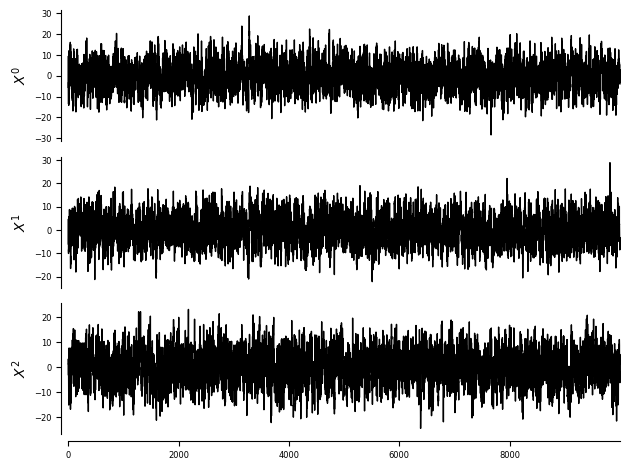

In [16]:
seed=1
random_state = np.random.default_rng(seed=seed)
T = 10000
# Generate 1/f noise by averaging AR1-process with wide range of coeffs 
# (http://www.scholarpedia.org/article/1/f_noise)
def one_over_f_noise(T, n_ar=20):
    whitenoise = random_state.standard_normal((T, n_ar))
    ar_coeffs = np.linspace(0.1, 0.9, n_ar)
    for t in range(T):
        whitenoise[t] += ar_coeffs*whitenoise[t-1]       
    return whitenoise.sum(axis=1)

data = random_state.standard_normal((T, 3))
data[:,0] += one_over_f_noise(T)
data[:,1] += one_over_f_noise(T)
data[:,2] += one_over_f_noise(T)

for t in range(1, T):
    data[t, 0] +=  0.4*data[t-1, 1] 
    data[t, 2] +=  0.3*data[t-2, 1] 
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()
# plt.psd(data[:,0],return_line=True)[2]
# plt.psd(data[:,1],return_line=True)[2]
# plt.psd(data[:,2],return_line=True)[2]
# plt.gca().set_xscale("log", nonposx='clip')
# plt.gca().set_yscale("log", nonposy='clip')

Here PCMCI will detect many spurious links, especially auto-dependencies, since the process has *long memory* and the present state is *not* independent of the further past given some set of parents. 

In [17]:
parcorr = ParCorr()
pcmci_parcorr = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
results = pcmci_parcorr.run_pcmci(tau_max=5, pc_alpha=0.2, alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 9 link(s):
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.601
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.294
        ($X^0$ -2): max_pval = 0.00000, min_val =  0.062
        ($X^0$ -4): max_pval = 0.00001, min_val =  0.044
        ($X^1$ -3): max_pval = 0.00480, min_val =  0.028
        ($X^0$ -5): max_pval = 0.00490, min_val =  0.028
        ($X^0$ -3): max_pval = 0.01260, min_val =  0.025
        ($X^1$ -4): max_pval = 0.05417, min_val = -0.019
        ($X^1$ -5): max_pval = 0.10577, min_val = -0.016

    Variable $X^1$ has 5 link(s):
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.615
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.073
        ($X^1$ -3): max_pval = 0.00613, min_val =  0.027
        ($X^2$ -2): max

#### Time aggregation

An important choice is how to aggregate measured time series. For example, climate time series might have been measured daily, but one might be interested in a less noisy time-scale and analyze monthly aggregates. Consider the following process:

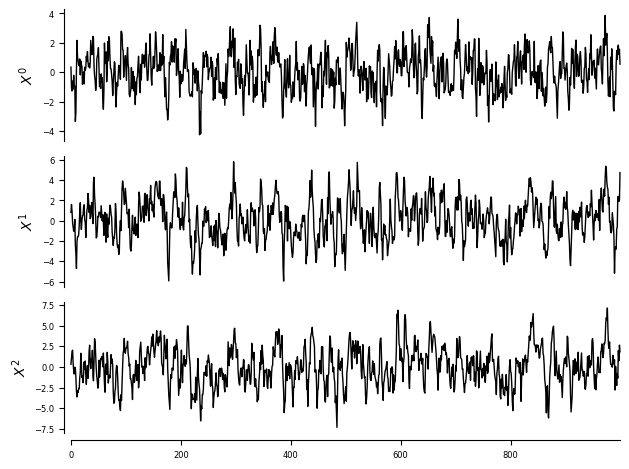

In [18]:
seed=1
random_state = np.random.default_rng(seed=seed)
data = random_state.standard_normal((1000, 3))

for t in range(1, 1000):
    data[t, 0] += 0.7*data[t-1, 0] 
    data[t, 1] += 0.6*data[t-1, 1] + 0.6*data[t-1,0]
    data[t, 2] += 0.5*data[t-1, 2] + 0.6*data[t-1,1]
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()

With the original time aggregation we obtain the correct causal graph:

In [19]:
pcmci_parcorr = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr())
results = pcmci_parcorr.run_pcmci(tau_min=0,tau_max=2, pc_alpha=0.2, alpha_level = 0.01)

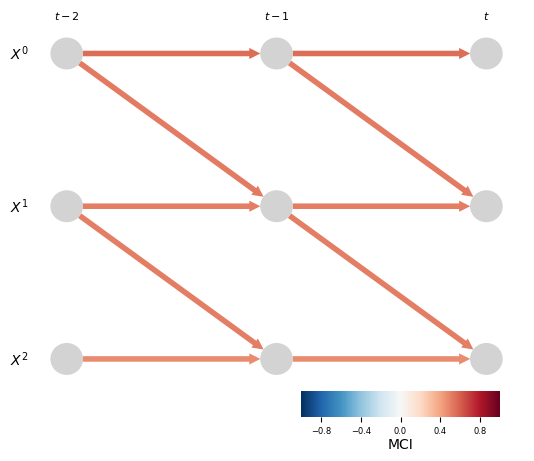

In [20]:
# Plot time series graph
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

If we aggregate the data, we also detect a contemporaneous dependency for which no causal direction can be assessed in this framework and we obtain also several lagged spurious links. Essentially, we now have direct causal effects that appear contemporaneous on the aggregated time scale. Also causal inference for time-aggregated data is still an active area of research. Note again that this constitutes a violation of the Markov Condition of the *observed process* only. So one might call this rather a violation of Causal Sufficiency.

In [21]:
aggregated_data = pp.time_bin_with_mask(data, time_bin_length=4)
pcmci_parcorr = PCMCI(dataframe=pp.DataFrame(aggregated_data[0], var_names=var_names), cond_ind_test=ParCorr(), 
                      verbosity=0)
results = pcmci_parcorr.run_pcmci(tau_min=0, tau_max=2, pc_alpha=0.2, alpha_level = 0.01)

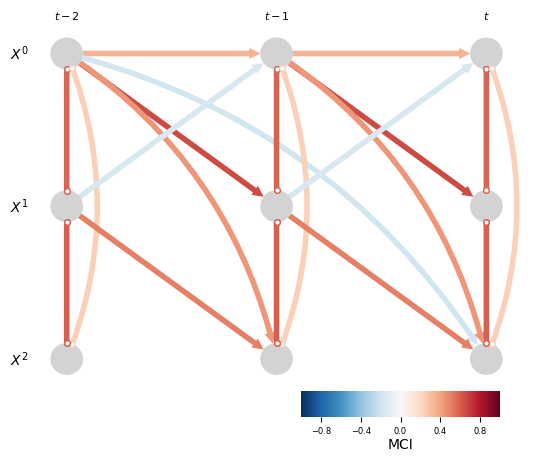

In [22]:
# Plot time series graph
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()